In [117]:
import geopandas
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from urllib.request import Request, urlopen
from zipfile import ZipFile
from io import BytesIO
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup

In [118]:
# months code
# 7001-7012 months
# 7016-7019 3-months
# 7020 year

# Analysis on Climate Change

In [119]:
def get_faostat_data(fao_url, file_name):
    req = Request(
        url = fao_url, 
        headers = {'User-Agent': 'Mozilla/5.0'}
    )

    with urlopen(req) as url:
        zfile = ZipFile(BytesIO(url.read()))
        data = pd.read_csv(zfile.open(file_name), encoding='latin')

    return data

In [120]:
def area_temp_change(df, area, interval='yearly'):
    area_temp = df[df['Area'] == area]

    if interval == 'yearly':
        month_codes = range(7020,7021)
    elif interval == 'monthly':
        month_codes = range(7001, 7013)
    elif interval == '3-months':
        month_codes = range(7016, 7020)
    else:
        print('months code:')
        print('"yearly" for years')
        print('"monthly" for months')
        print('"3-months" for 3-months')
        raise TypeError('Invalid time interval')

    result = area_temp[area_temp['Element'] == 'Temperature change']
    result = result.loc[result['Months Code'].isin(month_codes)]

    return result

In [121]:
temp_data = get_faostat_data('https://fenixservices.fao.org/faostat/static/bulkdownloads/Environment_Temperature_change_E_All_Data_(Normalized).zip',
                             'Environment_Temperature_change_E_All_Data_(Normalized).csv')

In [122]:
tr_yearly_temp_change = area_temp_change(temp_data, area='Türkiye', interval='yearly')
world_yearly_temp_change = area_temp_change(temp_data, area='World', interval='yearly')

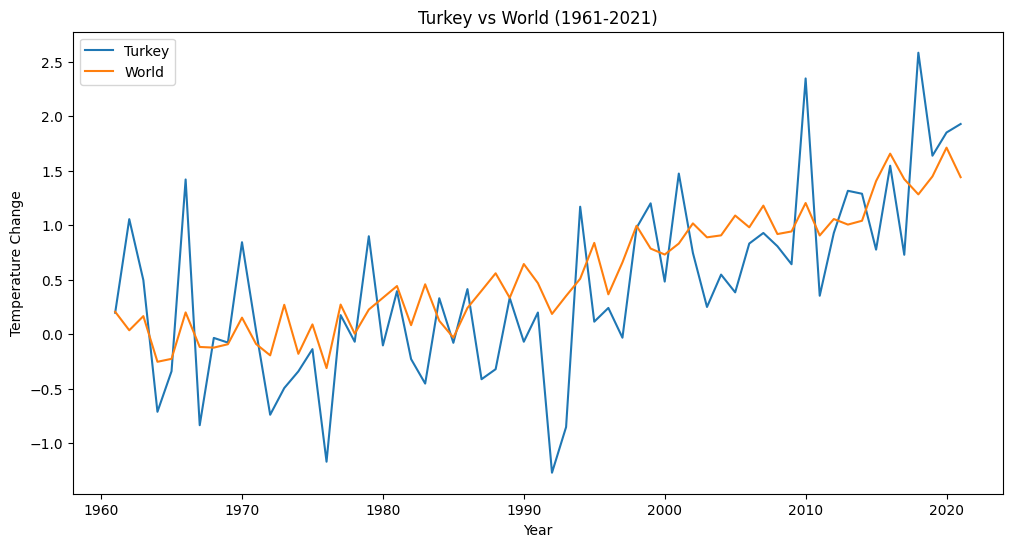

In [123]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(tr_yearly_temp_change['Year'], tr_yearly_temp_change['Value'], label='Turkey')
ax.plot(world_yearly_temp_change['Year'], world_yearly_temp_change['Value'], label='World')

ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change')
ax.set_title('Turkey vs World (1961-2021)')
ax.legend()

plt.show()

In [124]:
world_3months_temp_change = area_temp_change(temp_data, area='World', interval='3-months')
world_3months_temp_change = world_3months_temp_change.groupby(['Year', 'Months Code'], as_index=False).first()
world_3months_temp_change['Time'] = np.arange(len(world_3months_temp_change.index))

In [125]:
X_3months = world_3months_temp_change.loc[:, ['Time']]
y_3months = world_3months_temp_change.loc[:, 'Value'] 

lr_3months_model = LinearRegression()
lr_3months_model.fit(X_3months, y_3months)
pred_3months = lr_3months_model.predict(X_3months)

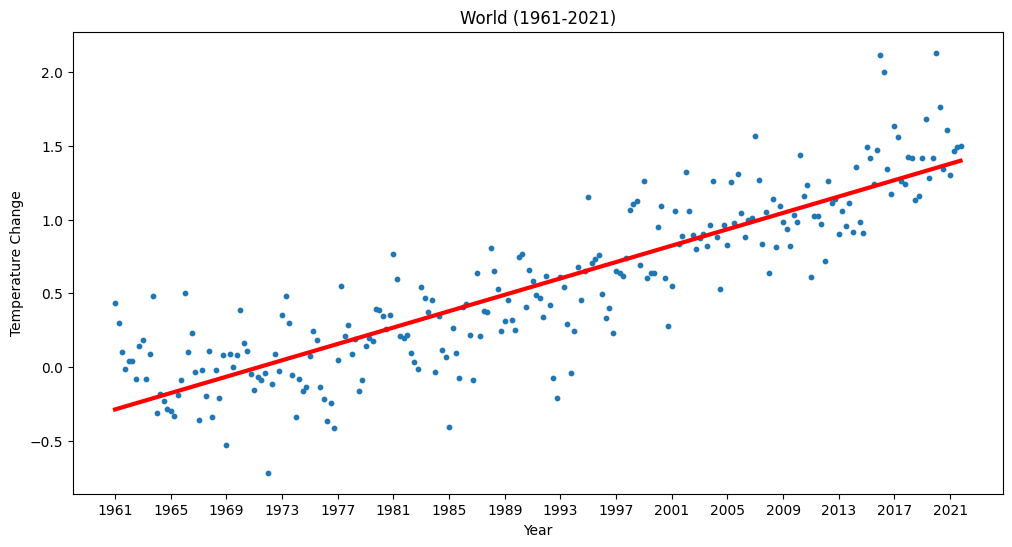

In [126]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(world_3months_temp_change['Time'], world_3months_temp_change['Value'], s=10)
ax.plot(world_3months_temp_change['Time'], pred_3months, color='red', linewidth=3)

ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change')
ax.set_title('World (1961-2021)')

ax.set_xticks(np.arange(max(world_3months_temp_change['Time']), step=16))
ax.set_xticklabels(np.arange(min(world_3months_temp_change['Year']), max(world_3months_temp_change['Year']+1), step=4))

plt.show()

From this gragh we can see that global temperature is rising.

In [127]:
print(f'model score: {lr_3months_model.score(X_3months, y_3months)}')
print(f'y = {lr_3months_model.coef_[0]}*X + ({lr_3months_model.intercept_})')

model score: 0.7605729396380649
y = 0.0069423916500419205*X + (-0.28764402810304424)


In [128]:
temp_change = temp_data[temp_data['Element'] == 'Temperature change']
temp_change_2012_2021 = temp_data.loc[temp_data['Year'].isin(range(2012, 2022))]
temp_change_2012_2021 = temp_change_2012_2021.loc[temp_data['Months Code'].isin(range(7020, 7021))]
temp_change_2012_2021_avg = temp_change_2012_2021.groupby(['Area'], as_index=False)[['Value']].mean()

In [129]:
country_geopandas = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
country_geopandas = country_geopandas.rename(columns={'name': 'Area'})

In [130]:
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('United Republic of Tanzania', 'Tanzania')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Western Sahara', 'W. Sahara')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Democratic Republic of the Congo', 'Dem. Rep. Congo')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Dominican Republic', 'Dominican Rep.')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Russian Federation', 'Russia')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Falkland Islands (Malvinas)', 'Falkland Is.', regex=False)
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Bolivia (Plurinational State of)', 'Bolivia', regex=False)
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Venezuela (Bolivarian Republic of)', 'Venezuela', regex=False)
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Central African Republic', 'Central African Rep.')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Equatorial Guinea', 'Eq. Guinea')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Eswatini', 'eSwatini')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace("Lao People's Democratic Republic", 'Laos')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Vietnam', 'Viet Nam')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace("Democratic People's Republic of Korea", 'North Korea')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Republic of Korea', 'South Korea')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Iran (Islamic Republic of)', 'Iran', regex=False)
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Syrian Arab Republic', 'Syria')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Republic of Moldova', 'Moldova')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Türkiye', 'Turkey')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Solomon Islands', 'Solomon Is.')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('China, Taiwan Province of', 'Taiwan')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Brunei Darussalam', 'Brunei')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('Bosnia and Herzegovina', 'Bosnia and Herz.')
temp_change_2012_2021_avg['Area'] = temp_change_2012_2021_avg['Area'].str.replace('South Sudan', 'S. Sudan')

In [131]:
cntry_temp = pd.merge(country_geopandas,
                      temp_change_2012_2021_avg.loc[temp_change_2012_2021_avg['Area'].isin(country_geopandas['Area'])])

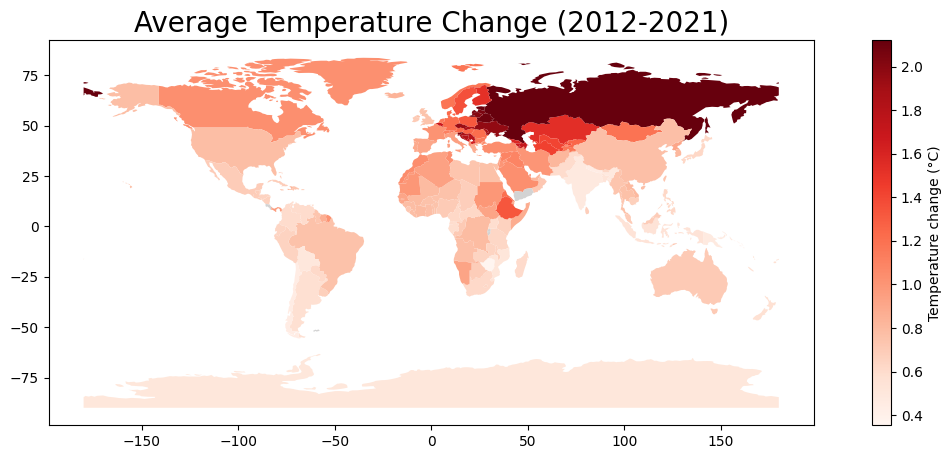

In [132]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Average Temperature Change (2012-2021)', size=20)
cntry_temp.plot(column='Value',
                cmap="Reds",
                ax=ax,
                missing_kwds={"color": "lightgrey"})
n = colors.Normalize(cntry_temp.Value.min(), cntry_temp.Value.max())
cbar = plt.cm.ScalarMappable(norm=n, cmap="Reds")
ax_cbar = fig.colorbar(cbar, ax=ax)
ax_cbar.set_label("Temperature change (°C)")

In [133]:
most_affected_10 = cntry_temp.dropna().sort_values('Value')[-10:]
least_affected_10 = cntry_temp.dropna().sort_values('Value')[:10]

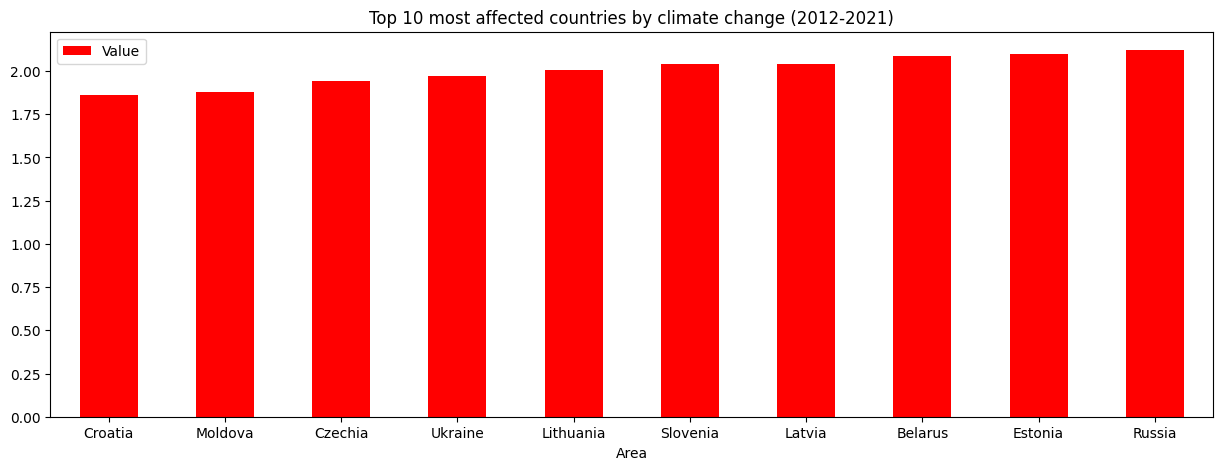

In [134]:
most_affected_10.plot.bar(x = 'Area',
                          title='Top 10 most affected countries by climate change (2012-2021)',
                          figsize=(15, 5),
                          rot=0,
                          color= 'red')
                          
plt.show()

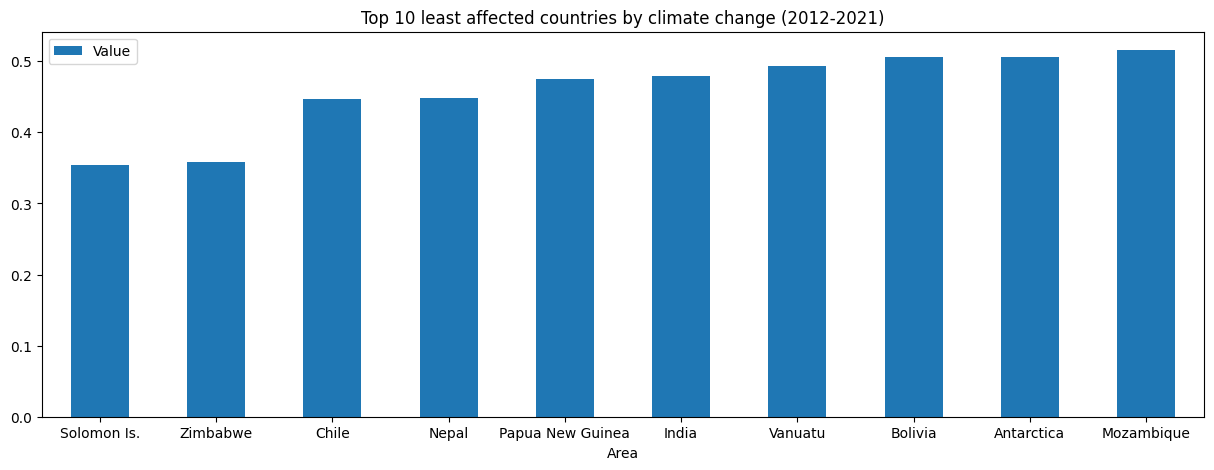

In [135]:
least_affected_10.plot.bar(x = 'Area',
                           title='Top 10 least affected countries by climate change (2012-2021)',
                           figsize=(15, 5),
                           rot=0)

plt.show()

In [136]:
annex1_yearly_temp_change = area_temp_change(temp_data, area='Annex I countries', interval='yearly')
nonannex1_yearly_temp_change  = area_temp_change(temp_data, area='Non-Annex I countries', interval='yearly')

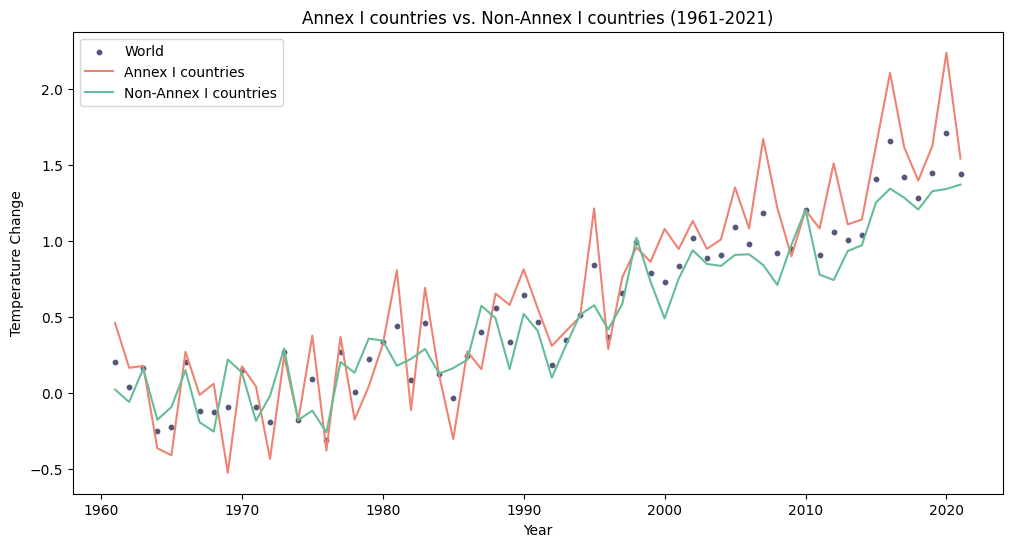

In [137]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(world_yearly_temp_change['Year'], world_yearly_temp_change['Value'], s=10, color='#54567a', label='World')
ax.plot(annex1_yearly_temp_change['Year'], annex1_yearly_temp_change['Value'], color='#ee8374', label='Annex I countries')
ax.plot(nonannex1_yearly_temp_change['Year'], nonannex1_yearly_temp_change['Value'], color='#64bd97', label = 'Non-Annex I countries')

ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change')
ax.set_title('Annex I countries vs. Non-Annex I countries (1961-2021)')
ax.legend()

plt.show()

In [138]:
world_winter_temp_change = world_3months_temp_change[world_3months_temp_change['Months Code'] == 7016]
world_spring_temp_change = world_3months_temp_change[world_3months_temp_change['Months Code'] == 7017]
world_summer_temp_change = world_3months_temp_change[world_3months_temp_change['Months Code'] == 7018]
world_fall_temp_change = world_3months_temp_change[world_3months_temp_change['Months Code'] == 7019]

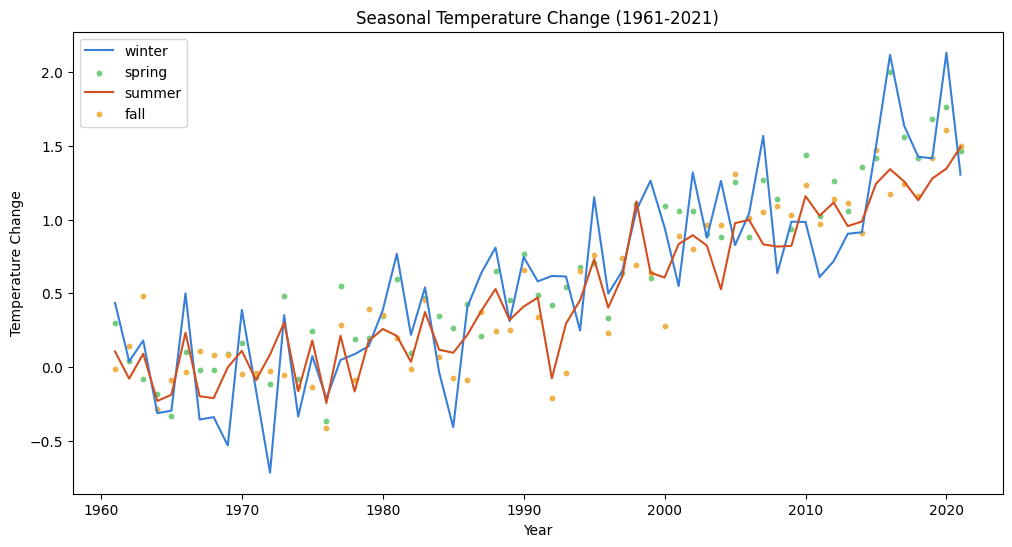

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(world_winter_temp_change['Year'], world_winter_temp_change['Value'], color='#377fd9', label = 'winter')
ax.scatter(world_spring_temp_change['Year'], world_spring_temp_change['Value'], color='#74cc7e', label = 'spring', s=10)
ax.plot(world_summer_temp_change['Year'], world_summer_temp_change['Value'], color='#d34f1e', label='summer')
ax.scatter(world_fall_temp_change['Year'], world_fall_temp_change['Value'], color='#f1b149', label='fall', s=10)

ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change')
ax.set_title('Seasonal Temperature Change (1961-2021)')
ax.legend()

plt.show()

In [140]:
X_summer = world_summer_temp_change.loc[:, ['Time']]
y_summer = world_summer_temp_change.loc[:, 'Value'] 

lr_summer_model = LinearRegression()
lr_summer_model.fit(X_summer, y_summer)
pred_summer = lr_summer_model.predict(X_summer)

In [141]:
X_winter = world_winter_temp_change.loc[:, ['Time']]
y_winter = world_winter_temp_change.loc[:, 'Value'] 

lr_winter_model = LinearRegression()
lr_winter_model.fit(X_winter, y_winter)
pred_winter = lr_winter_model.predict(X_winter)

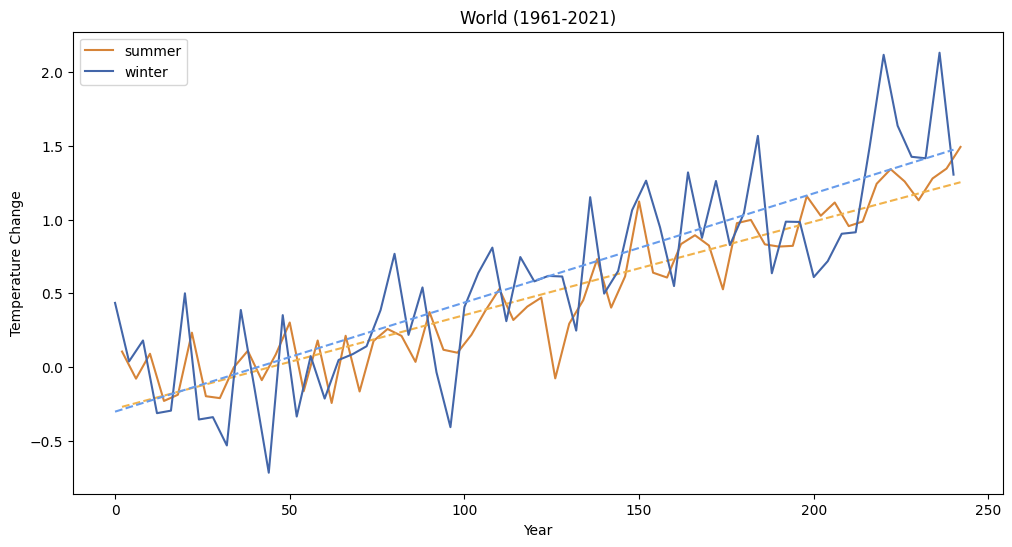

In [142]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(world_summer_temp_change['Time'], world_summer_temp_change['Value'], color='#d68438', label='summer')
ax.plot(world_summer_temp_change['Time'], pred_summer, color='#f1b24b', linestyle='--')

ax.plot(world_winter_temp_change['Time'], world_winter_temp_change['Value'], color='#4366a9', label='winter')
ax.plot(world_winter_temp_change['Time'], pred_winter, color='#679ceb', linestyle='--')

ax.set_xlabel('Year')
ax.set_ylabel('Temperature Change')
ax.set_title('World (1961-2021)')
ax.legend()

plt.show()

In [143]:
print(f'model score for winter: {lr_winter_model.score(X_winter, y_winter)}')
print(f'variance of true winter values: {np.var(y_winter)}')
print(f'variance of absolute error: {np.var(np.abs(y_winter - pred_winter))}')
print(f'y = {lr_winter_model.coef_[0]}*X + ({lr_winter_model.intercept_})')

model score for winter: 0.6801189391746896
variance of true winter values: 0.399759958075786
variance of absolute error: 0.04460972426815097
y = 0.007403741406663141*X + (-0.3027768376520359)


In [144]:
print(f'model score for summer: {lr_summer_model.score(X_summer, y_summer)}')
print(f'variance of true summer values: {np.var(y_summer)}')
print(f'variance of absolute error: {np.var(np.abs(y_summer - pred_summer))}')
print(f'y = {lr_summer_model.coef_[0]}*X + ({lr_summer_model.intercept_})')

model score for summer: 0.8497672677988408
variance of true summer values: 0.23523168341843592
variance of absolute error: 0.013711164514166164
y = 0.006348294553146483*X + (-0.282787017451084)
